HDF5 版の XGBoost

In [11]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

In [12]:
# 入力ファイルの皆さん

TRAINS = [
    "../hdf/train_categorical.hdf",
    "../hdf/train_numeric.hdf",
    "../hdf/train_date_L0.hdf",
    "../hdf/train_date_L1.hdf",
    "../hdf/train_date_L2.hdf",
    "../hdf/train_date_L3_normalized.hdf",
]

TESTS = []

for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
    
RESPONSE = "../hdf/train_response.hdf"

In [13]:
%%time
# 重要度を見てみる
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
columns = X.columns
y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()

CPU times: user 16.2 s, sys: 3.26 s, total: 19.4 s
Wall time: 21.7 s


CPU times: user 35min 31s, sys: 7.28 s, total: 35min 38s
Wall time: 2min 47s


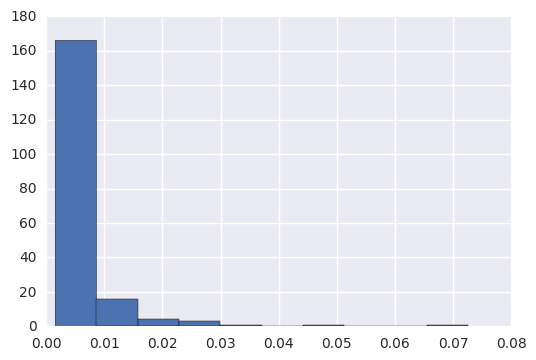

In [14]:
%%time
clf = XGBClassifier(base_score=0.005)
clf.fit(X.values, y)
plt.hist(clf.feature_importances_[clf.feature_importances_>0])

In [15]:
tuples = []
for i in range(len(columns)):
    fi = clf.feature_importances_[i]
    if fi <= 0.005:
        continue
    tuples.append((fi, columns[i]))
    
tuples = sorted(tuples, reverse=True)
for t in tuples:
    print(t)

(0.072530866, 'L3_S32_F3854')
(0.044753086, 'L3_S33_D3856')
(0.032407407, 'L1_S24_F1723')
(0.026234567, 'L3_S38_F3952')
(0.026234567, 'L3_S34_D3875')
(0.023148147, 'L3_S38_D3953')
(0.020061728, 'L3_S30_F3704')
(0.018518519, 'L1_S24_F867')
(0.016975308, 'L3_S33_F3865')
(0.016975308, 'L3_S32_D3852')
(0.015432099, 'L2_S26_D3037')
(0.015432099, 'L1_S24_F1604')
(0.013888889, 'L3_S33_F3859')
(0.012345679, 'L1_S24_F1498')
(0.010802469, 'L3_S37_D3942')
(0.010802469, 'L3_S30_F3754')
(0.010802469, 'L3_S30_F3744')
(0.010802469, 'L3_S30_D3496')
(0.010802469, 'L3_S29_F3339')
(0.010802469, 'L3_S29_D3474')
(0.0092592593, 'L3_S30_F3769')
(0.0092592593, 'L3_S30_D3566')
(0.0092592593, 'L3_S29_F3407')
(0.0092592593, 'L2_S26_F3040')
(0.0092592593, 'L1_S24_F1842')
(0.0092592593, 'L0_S12_D331')
(0.0077160494, 'L3_S36_F3920')
(0.0077160494, 'L3_S33_F3857')
(0.0077160494, 'L3_S29_F3345')
(0.0077160494, 'L3_S29_D3316')
(0.0077160494, 'L2_S27_F3166')
(0.0077160494, 'L2_S26_F3106')
(0.0077160494, 'L1_S24_F1494')

In [6]:
colums = [c[1] for c in tuples]
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
y = pd.read_hdf(RESPONSE)

In [7]:
X = X.loc[:, columns]
X = X.values
y = y.values.ravel()

In [8]:
%%time
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.716
fold 1, ROC AUC: 0.691
fold 2, ROC AUC: 0.692
0.699381828888
CPU times: user 1h 50min 36s, sys: 15.3 s, total: 1h 50min 51s
Wall time: 8min 29s


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.245326897727
CPU times: user 26.2 s, sys: 0 ns, total: 26.2 s
Wall time: 26.2 s


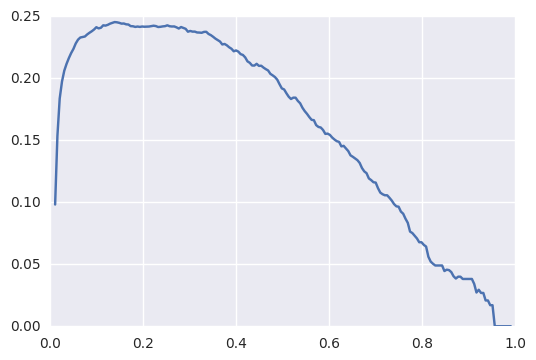

In [9]:
%%time
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [10]:
%%time
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_hdf(RESPONSE)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

CPU times: user 56 ms, sys: 112 ms, total: 168 ms
Wall time: 57 ms


提出用データを生成する

In [ ]:
# テストデータ読み込み
X = pd.concat((pd.read_hdf(filename) for filename in TESTS), axis=1)
index = X.index
X = X.values
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.DataFrame(index=index, columns=[])
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")